<img src='otus.png'>

In [1]:
from __future__ import division, print_function

from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
import warnings

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import scipy.stats as scs
from scipy.optimize import minimize

from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings('default')

C:\Users\ACLion\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Временные ряды

Временной ряд - последовательно измеренные через некоторые промежутки времени данные.

#### Примеры рядов и задач

* История объемов продаж магазина за 4 года с целью прогноза продаж на ближайшие два месяца и планирования логистики
* История онлайна игры с целью прогнозирования количества пользователей в онлайне
* Ежегодное число землетрясений в мире с сейсмической величиной более 7,0 в течение 99 лет подряд с целью прогноза количества замлетрясений в будущем году
* Ежеквартальное производство пива в Австралии в течение 18 лет с целью прогноза производства в будущем году

## Два способа решения подобных задач
* анализ и выделение параметров ряда
* превращение ряда в таблицу признаков и применение методов машинного обучения с учителем

Плюс возможно комбинирование методов в виде ансамблей - стекинг, блендинг

## Sales_Transactions_Dataset_Weekly Data Set 
Данные о недельных продажах более чем 800 продуктов за 52 недели  
https://archive.ics.uci.edu/ml/datasets/Sales_Transactions_Dataset_Weekly#  

In [2]:
data = pd.read_csv('Sales_Transactions_Dataset_Weekly.csv')
data = data.filter(regex=r'Product|W')
data.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9


In [3]:
len(data)

811

## Анализ параметров временного ряда

Выделим один продукт и посмотрим его продажи

см статью https://habrahabr.ru/company/ods/blog/327242/

In [4]:
values = data[data['Product_Code'] == 'P1'].filter(regex=r'W').as_matrix()[0]
values

array([11, 12, 10,  8, 13, 12, 14, 21,  6, 14, 11, 14, 16,  9,  9,  9, 14,
        9,  3, 12,  5, 11,  7, 12,  5,  9,  7, 10,  5, 11,  7, 10, 12,  6,
        5, 14, 10,  9, 12, 17,  7, 11,  4,  7,  8, 10, 12,  3,  7,  6,  5,
       10], dtype=int64)

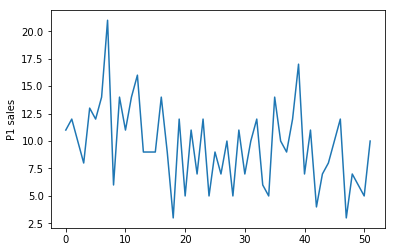

In [5]:
plt.plot(values)
plt.ylabel('P1 sales')
plt.show()

In [6]:
values[2:7].mean()


11.4

### Скользящее среднее

Предсказать можно только на один шаг вперед

In [7]:
n = 3
series = pd.Series(values)
rolling_mean = series.rolling(window=n).mean()

In [8]:
rolling_mean.head()

0          NaN
1          NaN
2    11.000000
3    10.000000
4    10.333333
dtype: float64

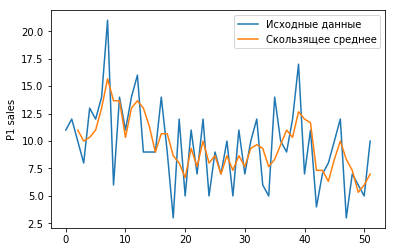

In [9]:
plt.plot(series, label=u"Исходные данные")
plt.plot(rolling_mean, label=u"Скользящее среднее")
plt.legend()
plt.ylabel('P1 sales')
plt.show()

## Экспоненциальное сглаживание
Предсказать можно только на один шаг вперед

$$S_t=\alpha x_t + \left( 1-\alpha \right) S_{t-1},  \alpha \in (0,1)$$

In [10]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [11]:
exp_sm = exponential_smoothing(series, 0.7)

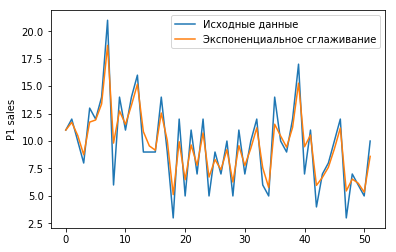

In [12]:
plt.plot(series, label=u"Исходные данные")
plt.plot(exp_sm, label=u"Экспоненциальное сглаживание")
plt.legend()
plt.ylabel('P1 sales')
plt.show()

## Другие методы

* Двойное экспоненциальное сглаживание (предсказать можно только на два шага вперед)
* Тройное экспоненциальное сглаживание (учитывает сезонность, например, месяц или неделя) 

## Cross-Validation на временном ряду 

(и на данных, где важно время достижения цели, например вернет или не вернет кредит)

Для предсказания можем использовать накопленные данные в прошлом, но нельзя заглядывать в будущее.  
Поэтому данные для кросс-валидации нельзя перемешивать.

<img src='cv.png'>

*Напоминание*  
Кросс-валидация применяется для вычисления качества модели таким образом, чтобы особенности данных не влияли на оценку (оценка должна быть несмещенной). Мы считаем среднюю оценку на подмножествах данных, чтобы не получить слишком пессиместичный или слишком оптимистичный прогноз.

см. также https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection

## Построение моделей на временных рядах, ARIMA

https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv

Подробно разобрано в статье
https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

In [13]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [14]:
ts = data['#Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

### Стационарность ряда

Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же гомоскедастичность) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями). Наглядно можно посмотреть на эти свойства на картинках, взятых из поста Sean Abu (http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/)

Матожидание:
<img src='ts1.png'>

Дисперсия:
<img src='ts2.png'>

Ковариация:
<img src='ts3.png'>

Предсказывать нужно именно эти характеристики, поэтому стационарность важна

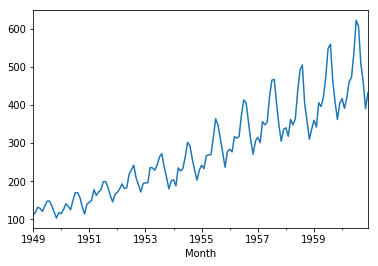

In [15]:
ts.plot()

## Тест на стационарность

Критерий Дики-Фуллера

см https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%94%D0%B8%D0%BA%D0%B8_%E2%80%94_%D0%A4%D1%83%D0%BB%D0%BB%D0%B5%D1%80%D0%B0  
http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html  

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

The p-values are obtained through regression surface approximation from MacKinnon 1994, but using the updated 2010 tables. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null.

The autolag option and maxlag for it are described in Greene.

C:\Users\ACLion\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
C:\Users\ACLion\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


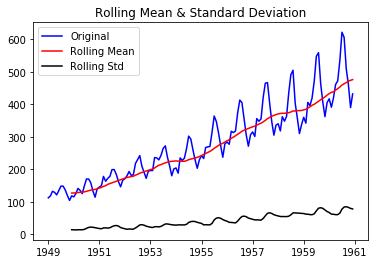

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [16]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    
test_stationarity(ts)

## Оценка и устранение тренда

Так или иначе данные необходимо трансформировать

* Агрегация - посчитать среднее за период
* Сглаживание
* Построение регрессионной модели (например полиномиальная регрессия)

### Сглаживание

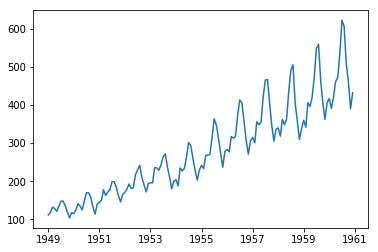

In [17]:
plt.plot(ts)

Приводим к стационарному - уменьшим абсолютные значения

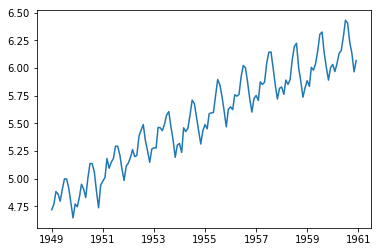

In [18]:
ts_log = np.log(ts)
plt.plot(ts_log)

Виден растущий тренд. Оценим его и вычтем из данных

C:\Users\ACLion\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.


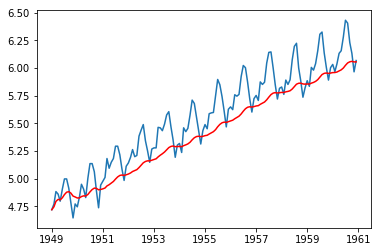

In [19]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

C:\Users\ACLion\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
C:\Users\ACLion\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


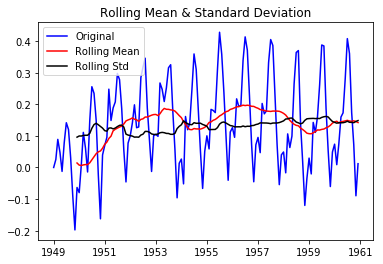

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [20]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

сравниваем Test Statistic и Critical Value. Если Test Statistic меньше Critical Value, то с 1-(p-value) вероятностью ряд стационарный

## Устранение тренда и сезонности 

* рассчет разности (Differencing)
* декомпозиция

### Разность

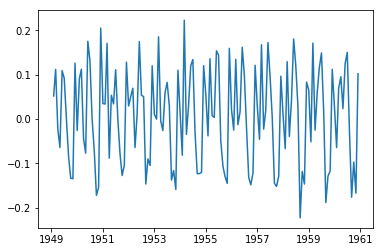

In [21]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

C:\Users\ACLion\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
C:\Users\ACLion\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


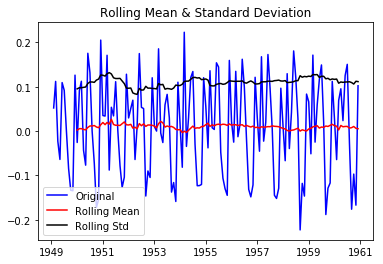

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [22]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Декомпозиция

Моделирование тренда и сезонности и их устранение

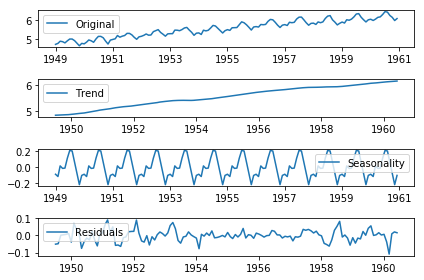

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

C:\Users\ACLion\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
C:\Users\ACLion\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


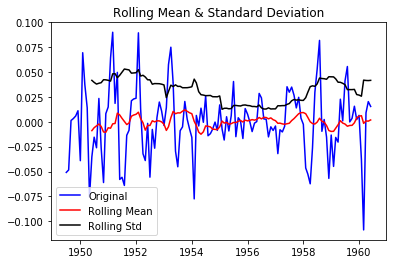

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [24]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

## ARIMA

* привести ряд к стационарному
* оценить начальные параметры
* настроить параметры модели
* обучить модель
* сделать предсказание


Auto-Regressive Integrated Moving Averages. 

ARIMA для стационарного ряда линейна.

Параметры:

* **p** - Number of AR (Auto-Regressive) terms  
На сколько шагов смотреть назад
* **q** - Number of MA (Moving Average) terms 
На сколько шагов смотреть назад ошибку предсказания (отличие от скользящего среднего)
* **d** - Number of Differences (d)
Длина сезона

In [25]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

**Autocorrelation Function (ACF)**  
Корреляция между рядом и сдвигом ряда  
**Partial Autocorrelation Function (PACF)**
Корреляция между рядом и сдвигом ряда после устранения эффектов в промежутке сдвига

In [26]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

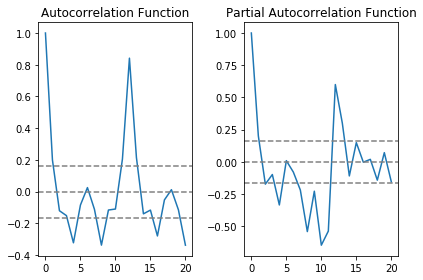

In [27]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Смотрим, где кривая пересекает верхний доверительный интервал первый раз.  
для q - ACF, p - PACF

In [28]:
q = 2
p = 2

In [29]:
from statsmodels.tsa.arima_model import ARIMA  # (p,d,q)

C:\Users\ACLion\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5,1,'RSS: 1.0292')

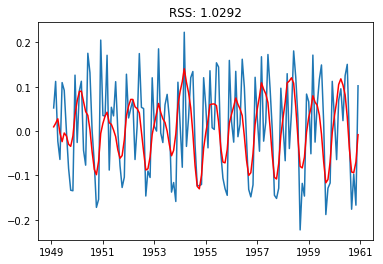

In [30]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

C:\Users\ACLion\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,'RMSE: 90.1046')

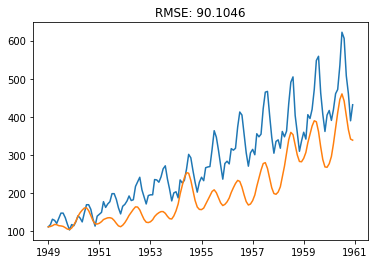

In [31]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [32]:
p = range(0, 5)
d = (1,)
q = range(0, 4)

from itertools import product

parameters = product(p, d, q)
parameters_list = list(parameters)
len(parameters_list)

20

In [33]:
for p, d, q in parameters_list:
    model = ARIMA(ts_log, order=(p, d, q))  
    results_ARIMA = model.fit(disp=-1)  
    rss = sum((results_ARIMA.fittedvalues - ts_log_diff)**2)
    print('for p={}, d={}, q={} RSS is {}'.format(p, d, q, rss))


for p=0, d=1, q=0 RSS is 1.612298185849133
for p=0, d=1, q=1 RSS is 1.524538157617147
for p=0, d=1, q=2 RSS is 1.472140134745266


C:\Users\ACLion\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


for p=0, d=1, q=3 RSS is 1.2783476044278173
for p=1, d=1, q=0 RSS is 1.5476170225252126
for p=1, d=1, q=1 RSS is 1.4597312968297873
for p=1, d=1, q=2 RSS is 1.2172999156052573
for p=1, d=1, q=3 RSS is 1.2169821275913613
for p=2, d=1, q=0 RSS is 1.5023033686758773
for p=2, d=1, q=1 RSS is 1.1753125298564722
for p=2, d=1, q=2 RSS is 1.029152002709352


C:\Users\ACLion\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


for p=2, d=1, q=3 RSS is 1.079379659047035
for p=3, d=1, q=0 RSS is 1.4880415240002287
for p=3, d=1, q=1 RSS is 1.159555257876108
for p=3, d=1, q=2 RSS is 1.1428398259005963
for p=3, d=1, q=3 RSS is 0.9832559304399882
for p=4, d=1, q=0 RSS is 1.3298806805265466
for p=4, d=1, q=1 RSS is 1.1087966988663325
for p=4, d=1, q=2 RSS is 1.0745239510723221
for p=4, d=1, q=3 RSS is 0.8759321765581896


C:\Users\ACLion\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5,1,'RSS: 0.9833')

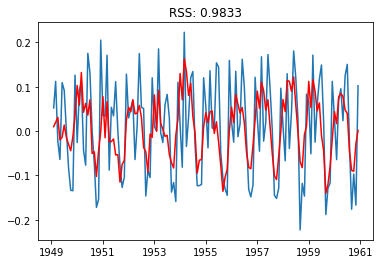

In [34]:
model = ARIMA(ts_log, order=(3, 1, 3))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Text(0.5,1,'RMSE: 81.5338')

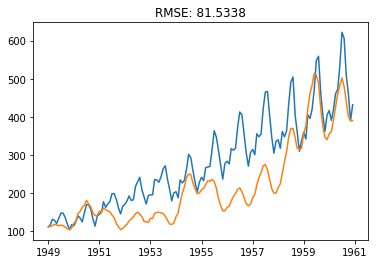

In [35]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

Какие есть достоинства и недостатки у такого подхода?

# Модели на признаках

Разобранный пример (MARIO FILHO, Kaggle Grandmaster)  
http://mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/  

In [39]:
data = pd.read_csv('Sales_Transactions_Dataset_Weekly.csv')
data = data.filter(regex=r'Product|W')
data.tail()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
806,P815,0,0,1,0,0,2,1,0,0,...,0,1,1,0,0,1,0,0,2,0
807,P816,0,1,0,0,1,2,2,6,0,...,3,3,4,2,4,5,5,5,6,5
808,P817,1,0,0,0,1,1,2,1,1,...,2,0,0,2,2,0,0,0,4,3
809,P818,0,0,0,1,0,0,0,0,1,...,0,0,0,1,1,0,0,0,2,0
810,P819,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [40]:
len(data)

811

Предсказать нужно для товара значение продаж в конкретную неделю.

Развернем данные таким образом, чтобы в строке были продукт, неделя и объем продаж. Также превратим строки в числа.

In [41]:
melt = data.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')
melt.tail()

,Product_Code,Week,Sales
42167,P815,W51,0
42168,P816,W51,5
42169,P817,W51,3
42170,P818,W51,0
42171,P819,W51,1


In [42]:
melt['Product_Code'] = melt['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
melt['Week'] = melt['Week'].str.extract('(\d+)', expand=False).astype(int)
melt = melt.sort_values(['Week', 'Product_Code'])

<input>:1: DeprecationWarning: invalid escape sequence \d
<input>:1: DeprecationWarning: invalid escape sequence \d
<input>:1: DeprecationWarning: invalid escape sequence \d
<input>:1: DeprecationWarning: invalid escape sequence \d
<input>:2: DeprecationWarning: invalid escape sequence \d
<input>:1: DeprecationWarning: invalid escape sequence \d
<input>:2: DeprecationWarning: invalid escape sequence \d
<input>:1: DeprecationWarning: invalid escape sequence \d
<input>:2: DeprecationWarning: invalid escape sequence \d
<input>:1: DeprecationWarning: invalid escape sequence \d
<input>:2: DeprecationWarning: invalid escape sequence \d
<input>:1: DeprecationWarning: invalid escape sequence \d
<input>:2: DeprecationWarning: invalid escape sequence \d
<input>:1: DeprecationWarning: invalid escape sequence \d
<input>:2: DeprecationWarning: invalid escape sequence \d
<ipython-input-42-27edcff45c91>:1: DeprecationWarning: invalid escape sequence \d
  melt['Product_Code'] = melt['Product_Code'].st

In [43]:
melt.head()

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


### Pandas shift and diff

In [44]:
test_df = pd.DataFrame({'x1': [0, 1, 2, 3, 4], 'x2': [5, 6, 7, 8, 9]})
test_df

,x1,x2
0,0,5
1,1,6
2,2,7
3,3,8
4,4,9


In [45]:
test_df['x3'] = test_df.x2.shift()
test_df

,x1,x2,x3
0,0,5,NaN
1,1,6,5.0
2,2,7,6.0
3,3,8,7.0
4,4,9,8.0


In [46]:
test_df['x4'] = test_df.x2.diff()
test_df

,x1,x2,x3,x4
0,0,5,NaN,NaN
1,1,6,5.0,1.0
2,2,7,6.0,1.0
3,3,8,7.0,1.0
4,4,9,8.0,1.0


### Применим к данным

Посчитаем продажи за предыдущую неделю (абсолютное значение продаж) и разницу в продажах за предыдущую и неделю перед ней (показывает тенденцию)

In [47]:
melt2 = melt.copy()
melt2['Last_Week_Sales'] = melt2.groupby(['Product_Code'])['Sales'].shift()
melt2['Last_Week_Diff'] = melt2.groupby(['Product_Code'])['Last_Week_Sales'].diff()  # do not look into the future!!!
melt2 = melt2.dropna()
melt2.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0


Нужно обратить внимание на то, что для построения корректной модели нельзя использовать значение Sales за текущую неделю для обучения, только для оценки модели.

In [48]:
melt[melt['Product_Code'] == 1].head()

,Product_Code,Week,Sales
0,1,0,11
811,1,1,12
1622,1,2,10
2433,1,3,8
3244,1,4,13


Будем считать RMLSE  
см. http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-log-error

This metric is best to use when targets having exponential growth, such as population counts, average sales of a commodity over a span of years etc. Note that this metric **penalizes an under-predicted estimate greater than an over-predicted estimate**.

Недооцененное штрафуем сильнее, чем переоцененное.

**Упражнение**: приведите пример из бизнеса, когда это хорошо, и когда это плохо.

По приведенным примерам стоит сделать вывод, что метрику нужно выбирать исходя из потребностей бизнеса. Если работаете с конкретным видом бизнеса, нужно изучить его особенности и риски, и убедиться, что метрика их учитывает.

In [49]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

## Baseline

В качестве предсказания возьмем данные за прошлую неделю

In [50]:
mean_error = []
for week in range(35, 45):
    
    # train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]
    
    p = val['Last_Week_Sales'].values
    
    error = rmsle(val['Sales'].values, p)
    
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 35 - Error 0.52516
Week 36 - Error 0.52266
Week 37 - Error 0.52061
Week 38 - Error 0.50225
Week 39 - Error 0.50874
Week 40 - Error 0.51952
Week 41 - Error 0.51691
Week 42 - Error 0.51026
Week 43 - Error 0.50792
Week 44 - Error 0.53409
Mean Error = 0.51681


Случайный лес

In [51]:
mean_error = []
for week in range(35, 45):
    
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
    
print('Mean Error = %.5f' % np.mean(mean_error))

Week 35 - Error 0.47095
Week 36 - Error 0.46897
Week 37 - Error 0.46669
Week 38 - Error 0.45113
Week 39 - Error 0.46696
Week 40 - Error 0.46242
Week 41 - Error 0.45964
Week 42 - Error 0.46166
Week 43 - Error 0.46655
Week 44 - Error 0.47122
Mean Error = 0.46462


Добавим еще информации о прошлом. Сделаем сдвиг еще на одну неделю и посчитаем разницу с предыдущей

In [65]:
melt3 = melt.copy()
melt3['Last_Week_Sales'] = melt3.groupby(['Product_Code'])['Sales'].shift()
melt3['Last_Week_Diff'] = melt3.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt3['Last-1_Week_Sales'] = melt3.groupby(['Product_Code'])['Sales'].shift(2)
melt3['Last-1_Week_Diff'] = melt3.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
melt3 = melt3.dropna()
melt3.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff
2433,1,3,8,10.0,-2.0,12.0,1.0
2434,2,3,2,3.0,-3.0,6.0,-1.0
2435,3,3,9,8.0,-3.0,11.0,4.0
2436,4,3,5,13.0,5.0,8.0,-4.0
2437,5,3,11,13.0,8.0,5.0,-3.0


In [74]:

mean_error = []
for week in range(35, 45):
    train = melt3[melt3['Week'] < week]
    val = melt3[melt3['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 35 - Error 0.45757
Week 36 - Error 0.45999
Week 37 - Error 0.44553
Week 38 - Error 0.42702
Week 39 - Error 0.45642
Week 40 - Error 0.44389
Week 41 - Error 0.45812
Week 42 - Error 0.43652
Week 43 - Error 0.44033
Week 44 - Error 0.46318
Mean Error = 0.44886


То же самое, но добавим еще данных

In [75]:
melt4 = melt.copy()
melt4['Last_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift()
melt4['Last_Week_Diff'] = melt4.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt4['Last-1_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift(2)
melt4['Last-1_Week_Diff'] = melt4.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
melt4['Last-2_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift(3)
melt4['Last-2_Week_Diff'] = melt4.groupby(['Product_Code'])['Last-2_Week_Sales'].diff()
melt4 = melt4.dropna()
melt4.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
3244,1,4,13,8.0,-2.0,10.0,-2.0,12.0,1.0
3245,2,4,7,2.0,-1.0,3.0,-3.0,6.0,-1.0
3246,3,4,10,9.0,1.0,8.0,-3.0,11.0,4.0
3247,4,4,9,5.0,-8.0,13.0,5.0,8.0,-4.0
3248,5,4,6,11.0,-2.0,13.0,8.0,5.0,-3.0


In [77]:
mean_error = []
for week in range(35, 45):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 35 - Error 0.44905
Week 36 - Error 0.44012
Week 37 - Error 0.44149
Week 38 - Error 0.42865
Week 39 - Error 0.43850
Week 40 - Error 0.43096
Week 41 - Error 0.43894
Week 42 - Error 0.42754
Week 43 - Error 0.41965
Week 44 - Error 0.44807
Mean Error = 0.43630


Сейчас мы оптимизировали MSE, а проверяли MSLE.  
Логарифмируем целевую переменную и обучим модель.

In [78]:
mean_error = []
for week in range(35, 45):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 35 - Error 0.43496
Week 36 - Error 0.43031
Week 37 - Error 0.42514
Week 38 - Error 0.41451
Week 39 - Error 0.42247
Week 40 - Error 0.41695
Week 41 - Error 0.42215
Week 42 - Error 0.41215
Week 43 - Error 0.40363
Week 44 - Error 0.43325
Mean Error = 0.42155


Градиентный бустинг

In [79]:
mean_error = []
for week in range(35, 45):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

/usr/local/lib/python2.7/dist-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/usr/local/lib/python2.7/dist-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


Week 35 - Error 0.40681
Week 36 - Error 0.40324
Week 37 - Error 0.40217
Week 38 - Error 0.39360
Week 39 - Error 0.39439
Week 40 - Error 0.40811
Week 41 - Error 0.39795
Week 42 - Error 0.39533
Week 43 - Error 0.39488
Week 44 - Error 0.42019
Mean Error = 0.40167


/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


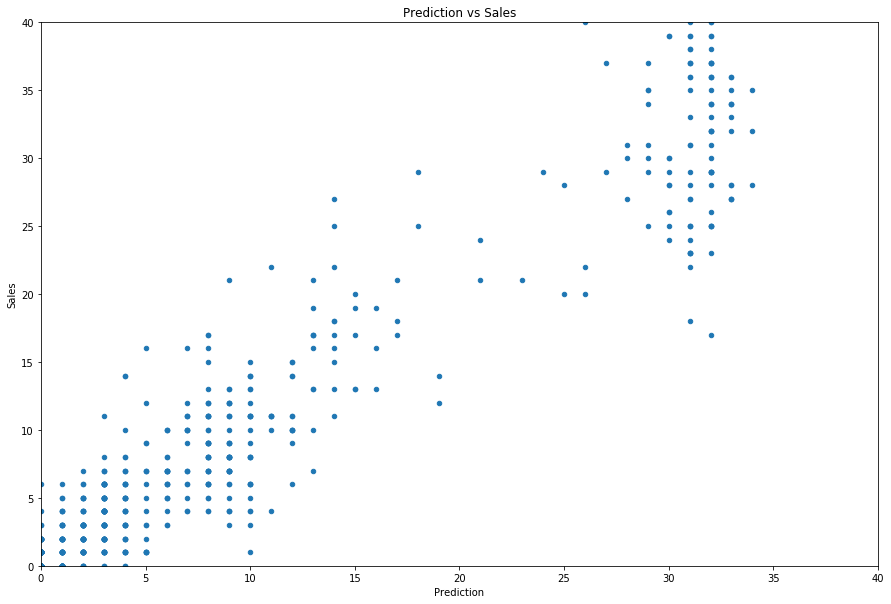

In [80]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Sales', figsize=(15,10), title='Prediction vs Sales', 
                 ylim=(0,40), xlim=(0,40))

Попробуем скользящее окно - посчитаем среднее.

In [94]:
window = 8
mean_error = []
for week in range(35, 45):
    
    train = melt2[(melt2['Week'] > week - window) & (melt2['Week'] < week)]
    val = melt2[melt2['Week'] == week]
    
    p = train.groupby(['Product_Code'])['Last_Week_Sales'].mean()
    
    error = rmsle(val['Sales'].values, p)
    
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 35 - Error 0.39333
Week 36 - Error 0.39075
Week 37 - Error 0.38139
Week 38 - Error 0.38068
Week 39 - Error 0.38949
Week 40 - Error 0.39023
Week 41 - Error 0.38346
Week 42 - Error 0.39266
Week 43 - Error 0.38671
Week 44 - Error 0.40399
Mean Error = 0.38927


In [98]:
for week in range(45, 52):
    
    train = melt2[(melt2['Week'] > week - window) & (melt2['Week'] < week)]
    val = melt2[melt2['Week'] == week]
    
    p = train.groupby(['Product_Code'])['Last_Week_Sales'].mean()
    
    error = rmsle(val['Sales'].values, p)
    
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 45 - Error 0.36912
Week 46 - Error 0.39250
Week 47 - Error 0.38720
Week 48 - Error 0.38820
Week 49 - Error 0.38552
Week 50 - Error 0.41411
Week 51 - Error 0.47663
Mean Error = 0.39663


1. https://habrahabr.ru/company/ods/blog/327242/ Вводная статья по основным методам прогнозирования временных рядов
2. https://onlinecourses.science.psu.edu/stat510/ Онлайн курс по временным рядам
2. https://habrahabr.ru/company/ods/blog/327242/ Описаны техники mean encoding, кросс-валидация на временном ряду для xgb
1. http://www.statsmodels.org/dev/examples/index.html